In [138]:
import numpy as np
import matplotlib.pyplot as plt

import kalepy as kale

import holodeck as holo
from holodeck.constants import MSOL

See [Leja+2020 - A New Census of the 0.2 < z < 3.0 Universe. I. The Stellar Mass Function ](https://ui.adsabs.harvard.edu/abs/2020ApJ...893..111L/abstract)

# GSMF

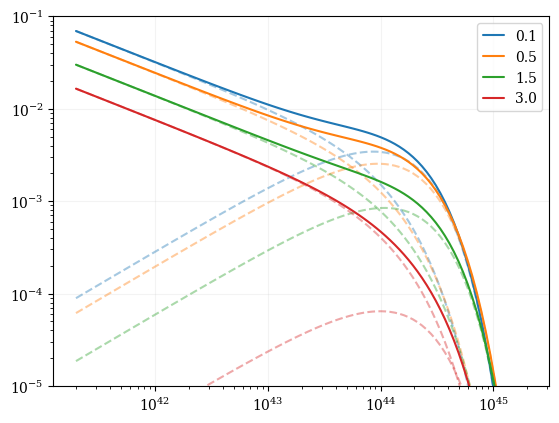

In [141]:
gsmf = holo.sams.comps.GSMF_Double_Schechter()

mstar = np.logspace(8, 12, 100) * MSOL

for redz in [0.1, 0.5, 1.5, 3.0]:

    phi = gsmf(mstar, redz)
    cc, = plt.loglog(mstar, phi, label=redz)
    cc = cc.get_color()

    phi = gsmf._gsmf_one(mstar, redz)
    plt.loglog(mstar, phi, ls='--', color=cc, alpha=0.4)
    phi = gsmf._gsmf_two(mstar, redz)
    plt.loglog(mstar, phi, ls='--', color=cc, alpha=0.4)

ax = plt.gca()
ylim = [1e-5, 1e-1]
ax.set(ylim=ylim)
ax.legend()
plt.show()

# Parameters

**Fits derived below**

In [99]:
print(f"{'logphi1':>10s} : c0 = $ -2.383 \pm 0.027$")
print(f"{'logphi1':>10s} : c1 = $ -0.264 \pm 0.071$")
print(f"{'logphi1':>10s} : c2 = $ -0.107 \pm 0.030$")
print(f"{'logphi2':>10s} : c0 = $ -2.818 \pm 0.050$")
print(f"{'logphi2':>10s} : c1 = $ -0.368 \pm 0.070$")
print(f"{'logphi2':>10s} : c2 = $ +0.046 \pm 0.020$")
print(f"{'logmstar':>10s} : c0 = $+10.767 \pm 0.026$")
print(f"{'logmstar':>10s} : c1 = $ +0.124 \pm 0.045$")
print(f"{'logmstar':>10s} : c2 = $ -0.033 \pm 0.015$")

   logphi1 : c0 = $ -2.383 \pm 0.027$
   logphi1 : c1 = $ -0.264 \pm 0.071$
   logphi1 : c2 = $ -0.107 \pm 0.030$
   logphi2 : c0 = $ -2.818 \pm 0.050$
   logphi2 : c1 = $ -0.368 \pm 0.070$
   logphi2 : c2 = $ +0.046 \pm 0.020$
  logmstar : c0 = $+10.767 \pm 0.026$
  logmstar : c1 = $ +0.124 \pm 0.045$
  logmstar : c2 = $ -0.033 \pm 0.015$


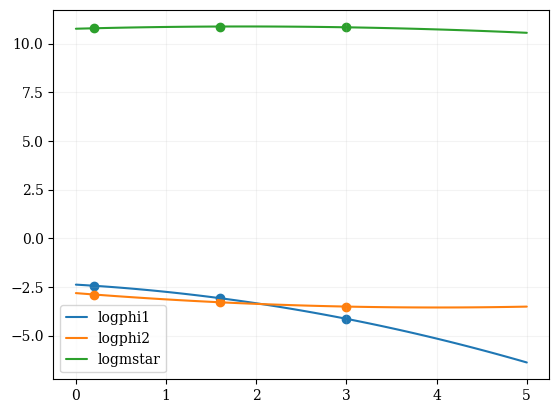

In [32]:
# parameters from [Leja+2020]_ Fig.3 also in Appendix B code snippet
pars = {
    'logphi1': [-2.44, -3.08, -4.14],
    'logphi1_err': [0.02, 0.03, 0.1],
    'logphi2': [-2.89, -3.29, -3.51],
    'logphi2_err': [0.04, 0.03, 0.03],
    'logmstar': [10.79, 10.88, 10.84],
    'logmstar_err': [0.02, 0.02, 0.04],
    'alpha1': [-0.28],
    'alpha1_err': [0.07],
    'alpha2': [-1.48],
    'alpha2_err': [0.01],
}

# ZVALS = [3.0, 1.6, 0.2]
ZVALS = [0.2, 1.6, 3.0]

def get_cs(yy):
    z1, z2, z3 = ZVALS
    y1, y2, y3 = yy

    # calculate 'a' - z^2 prefactor
    tt = (z1 - z3) / (z2 - z1)
    denom = (z2**2 - z1**2) * tt
    denom = z3**2 - z1**2 + denom
    numer = (y3 - y1) + (y2 - y1) * tt
    c2 = numer / denom

    # calculate 'b' - z prefactor
    c1 = y2 - y1 - c2*(z2**2 - z1**2)
    c1 /= (z2 - z1)
    
    # calculate 'c' - constant term
    c0 = y1 - c2*z1**2 - c1*z1
    cc = [c0, c1, c2]

    return cc


def use_cs(zz, cc):
    yy = cc[0] + cc[1]*zz + cc[2]*(zz**2)
    # yy = cc[2] + cc[1]*zz + cc[0]*(zz**2)
    return yy


fig, ax = plt.subplots()
for par in ['logphi1', 'logphi2', 'logmstar']:
    par_yy = pars[par]
    par_cs = get_cs(par_yy)
    redz = np.linspace(0.0, 5.0, 100)
    yy = use_cs(redz, par_cs)

    ax.plot(redz, yy, label=par)
    ax.scatter(ZVALS, par_yy)

ax.legend()
plt.show()

[-2.44 -3.08 -4.14] [0.02 0.03 0.1 ]


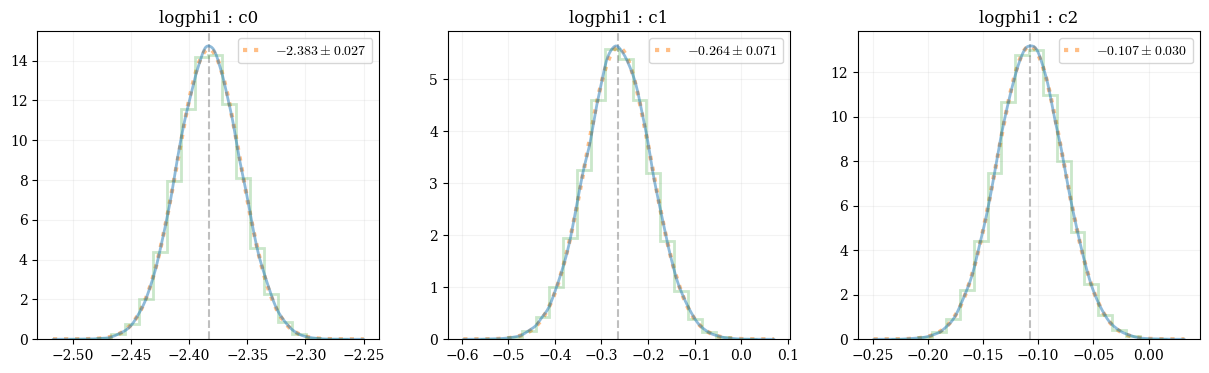

In [87]:
NUM = 1e5
par = 'logphi1'
yave = np.array(pars[par])
yerr = np.array(pars[par + "_err"])

yy = np.random.normal(yave[:, np.newaxis], yerr[:, np.newaxis], size=(3, int(NUM)))

cs = get_cs(yy)
cave = get_cs(yave)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
for ii, ax in enumerate(axes):
    ax.set_title(f"{par} : c{ii}")
    ax.axvline(cave[ii], color='k', ls='--', alpha=0.25)

    aa, bb = kale.density(cs[ii], probability=True)
    ax.plot(aa, bb, alpha=0.5, zorder=10, lw=2.0)

    ave = np.mean(cs[ii])
    std = np.std(cs[ii])
    popt, pcov = holo.utils.fit_gaussian(aa, bb, guess=[bb.max(), ave, std])

    bb = holo.utils._func_gaussian(aa, *popt)
    lab = f"${popt[1]:.3f} \pm {popt[2]:.3f}$"
    ax.plot(aa, bb, alpha=0.5, ls=':', lw=3.0, label=lab)
        
    ax.hist(cs[ii], bins=20, histtype='step', density=True, alpha=0.25, lw=2.0)

    ax.legend()
    
plt.show()



   logphi1 : c0 -- $ -2.383 \pm 0.027$
   logphi1 : c1 -- $ -0.264 \pm 0.071$
   logphi1 : c2 -- $ -0.107 \pm 0.030$
   logphi2 : c0 -- $ -2.818 \pm 0.050$
   logphi2 : c1 -- $ -0.368 \pm 0.070$
   logphi2 : c2 -- $ +0.046 \pm 0.020$
  logmstar : c0 -- $+10.767 \pm 0.026$
  logmstar : c1 -- $ +0.124 \pm 0.045$
  logmstar : c2 -- $ -0.033 \pm 0.015$


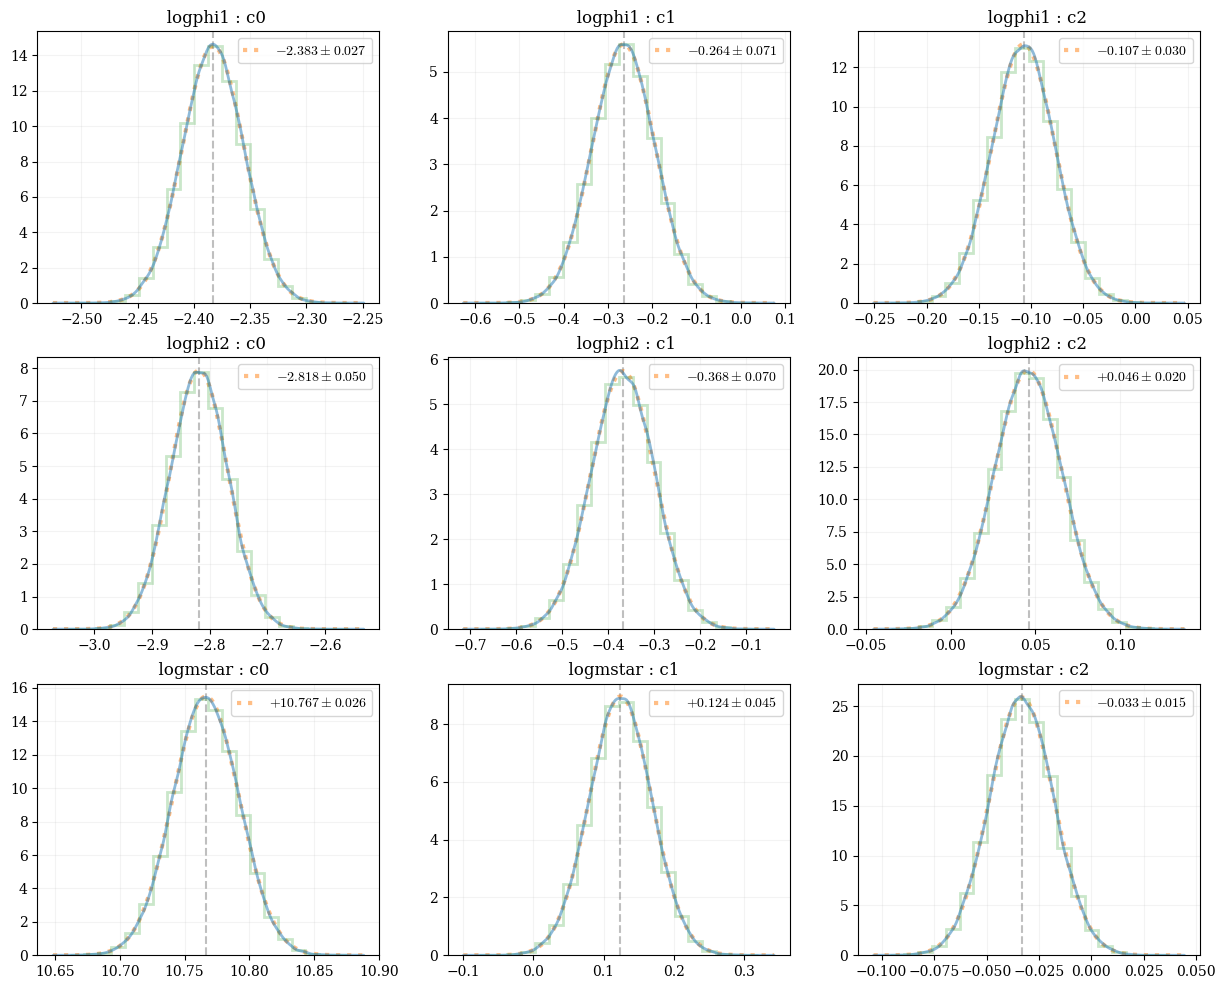

In [97]:
NUM = 1e5

fig, axes = plt.subplots(figsize=[15, 12], ncols=3, nrows=3)

for jj, par in enumerate(['logphi1', 'logphi2', 'logmstar']):
    axrow = axes[jj]

    yave = np.array(pars[par])
    yerr = np.array(pars[par + "_err"])

    yy = np.random.normal(yave[:, np.newaxis], yerr[:, np.newaxis], size=(3, int(NUM)))

    cs = get_cs(yy)
    cave = get_cs(yave)

    for ii, ax in enumerate(axrow):
        title = f"{par:>10s} : c{ii}"
        ax.set_title(title)
        ax.axvline(cave[ii], color='k', ls='--', alpha=0.25)

        aa, bb = kale.density(cs[ii], probability=True)
        ax.plot(aa, bb, alpha=0.5, zorder=10, lw=2.0)

        ave = np.mean(cs[ii])
        std = np.std(cs[ii])
        popt, pcov = holo.utils.fit_gaussian(aa, bb, guess=[bb.max(), ave, std])

        bb = holo.utils._func_gaussian(aa, *popt)
        lab = f"${popt[1]:+7.3f} \pm {popt[2]:.3f}$"
        print(title + " -- " + lab)
        ax.plot(aa, bb, alpha=0.5, ls=':', lw=3.0, label=lab)
            
        ax.hist(cs[ii], bins=20, histtype='step', density=True, alpha=0.25, lw=2.0)

        ax.legend()
    
plt.show()

